
- Most Quantum Cloud Services (QCS) users will want to use the Rigetti-hosted JupyterLab IDE to get a personal development environment with everything they need to get started. In some cases, users may choose to Install Locally. However, support for running from a local environment is limited.
- Installing locally is most useful for development using a Quantum Virtual Machine (QVM). Running programs against a QPU requires a reservation as well as network access to the QPU (available via your provisioned JupyterLab IDE).
- To make full use of pyQuil, you’ll want to have both the Quantum Virtual Machine (QVM) and the Quil Compiler (quilc) installed


## Version Information

<table align="left">
  <thead>
    <tr>
      <th>Component</th>
      <th>Version</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>python</td>
      <td>3.11.5</td>
    </tr>
    <tr>
      <td>pyquil</td>
      <td>4.10.0</td>
    </tr>
  </tbody>
</table>

</table>


In [121]:
import math
from pyquil import Program
from pyquil.gates import *
from pyquil.api import get_qc
import matplotlib.pyplot as plt
import networkx as nx
from pyquil.latex import to_latex, display, DiagramSettings

from sympy import isprime
import random
from fractions import Fraction

After install and activate docker on the machine, run the following commands:

- `docker run --rm -it -p 5555:5555 rigetti/quilc -P -S`

- `docker run --rm -it -p 5000:5000 rigetti/qvm -S`

In [122]:
# # run the program on a QVM
# qc = get_qc('9q-square-qvm')
# result = qc.run(qc.compile(p)).get_register_map().get("ro")
# print(result[0])
# print(result[1])

In [123]:
def find_all_as(N):
    ns=[]
    for n in range(2,N):
        if math.gcd(n,N)==1:
            ns.append(n)
    return ns

def validate_a(a):
    ns = find_all_as(N)
    if a not in ns:
        raise ValueError(f"'a' must be one of {ns}")
    return True

def get_nlen_mlen(N):       
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    return n_len, m_len 

def is_power_of_prime(N):
    for base in range(2, int(math.sqrt(N)) + 1):
        power = 2
        while (result := base ** power) <= N:
            if result == N:
                return True
            power += 1
    return False

def validate_N(N):
    if isprime(N):
        raise ValueError(f"{N} is a prime.")
    if is_power_of_prime(N):
        raise ValueError(f"{N} is a power of a prime.")
    return True


def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False
    
    
# 100 of prime numbers
prime_100 = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 
             107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 
             227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 
             349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 
             467, 479, 487, 491, 499, 503, 509, 521, 523, 541]

def generate_N():
    ACCEPTED_N = False
    max_qubits = 29
    while not ACCEPTED_N:
        ps = random.sample(prime_100[5:], 2)
        N = ps[0]*ps[1]
        n_len, m_len = get_nlen_mlen(N)
        if n_len+m_len<=max_qubits:
            print(f"N = {ps[0]} * {ps[1]} = {N}")
            return N

In [138]:
def get_nlen_mlen(N):       
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    return n_len, m_len 

def initiate_qc(N):
    n_len, m_len = get_nlen_mlen(N)
    qc = Program()
    for q in range(m_len):
        qc += H(q)
    qc += X(m_len)
    
    return qc

def append_c_amodN(qc, a, N):
    n_len, m_len = get_nlen_mlen(N)
    
    for q in range(m_len):
        pwr = 2 ** q
        for i, bit in enumerate(format(pow(a, pwr, N) ^ 1, f'0{n_len}b')):
            if bit == '1':
                qc += CNOT(q, i + m_len)
    return qc
    

def append_IQFT(qc, N):
    _, m_len = get_nlen_mlen(N)

    for q in range(m_len // 2):
        qc += SWAP(q, m_len - q - 1)
    
    # Apply QFT† gates
    for j in range(m_len):
        for m in range(j):
            angle = -np.pi / float(2 ** (j - m))
            qc += CPHASE(angle, m, j)
        qc += H(j)
    
    return qc


def simulation(qc, N):
    n_len, m_len = get_nlen_mlen(N)
    total_qubits = n_len+m_len
    
    simulator = get_qc(f'{total_qubits}q-qvm')
    compiled_circuit = simulator.compile(qc)

#     result = simulator.run(compiled_circuit).readout_data
    result = simulator.run(compiled_circuit).get_register_map()
    
    return [''.join(map(str, row))[::-1] for row in result['ro']]

# ro = "readout" as key of the result
def shor_qc(a, N):
    _, m_len = get_nlen_mlen(N)
    
    qc = initiate_qc(N)
    qc = append_c_amodN(qc, a, N)
    qc = append_IQFT(qc, N)
    
    # Measure the first m_len qubits
    ro = qc.declare('ro', 'BIT', m_len)
    for i in range(m_len):
        qc += MEASURE(i, ro[i])

    
    return simulation(qc, N)


{'ro': array([[0, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)}

** The following digram without IQFT due to an error of drawing not in the circuit, limitation of the platform **


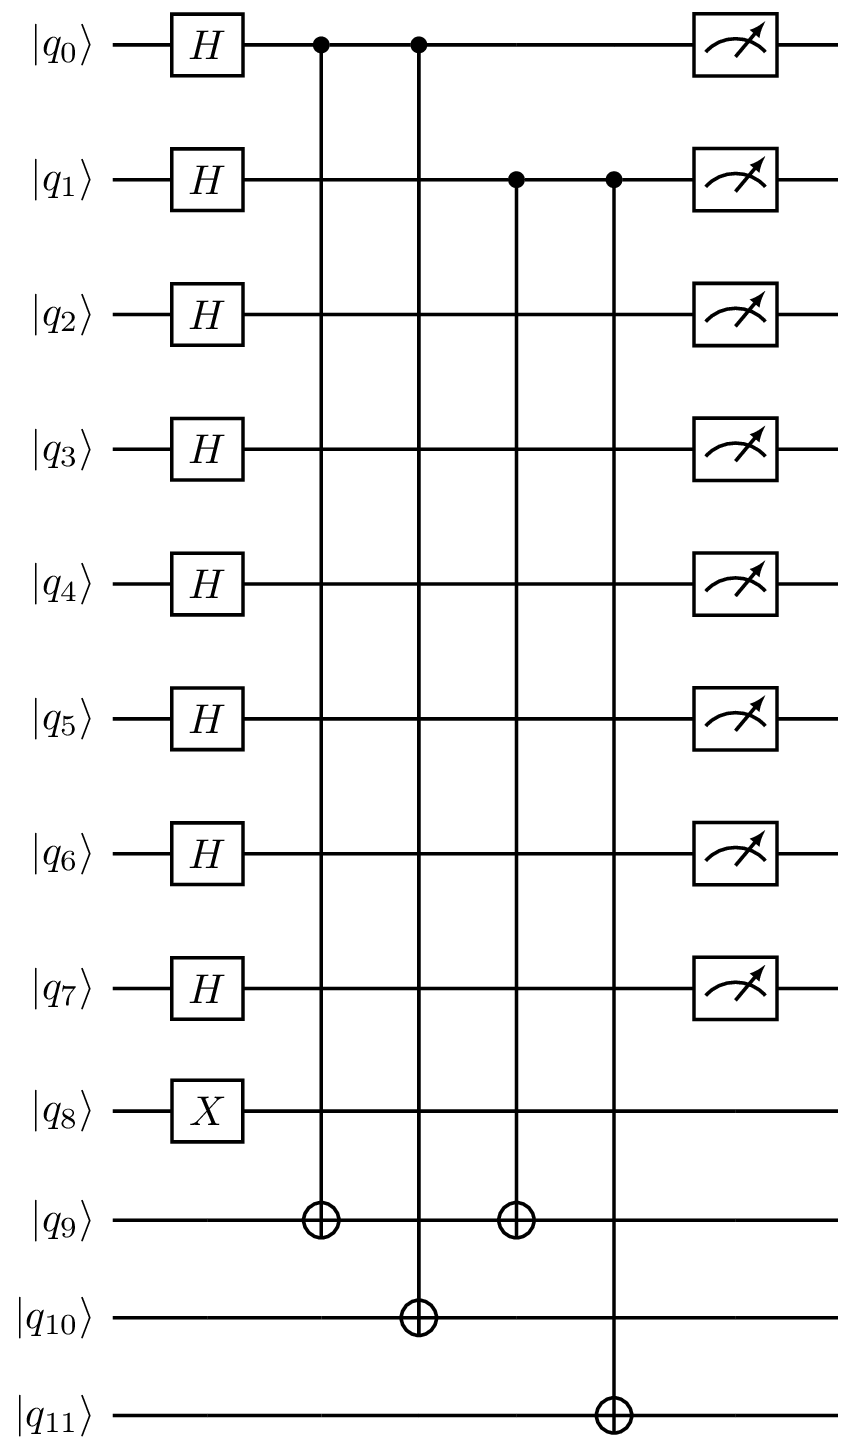

In [139]:
# Example usage
N = 15
a = 7
qc = initiate_qc(N)
qc = append_c_amodN(qc, a, N)
# qc = append_IQFT(qc,N)


# Measure the first m_len qubits
ro = qc.declare('ro', 'BIT', m_len)
for i in range(m_len):
    qc += MEASURE(i, ro[i])
    

# Print the result
print(result)
print('\n** The following digram without IQFT due to an error of drawing not in the circuit, limitation of the platform **')
display(qc)

In [144]:
FACTOR_FOUND = False
ATTEMPT = 0

N = 15
# validate_N(N)  # no need to validate N value

n_len, m_len = get_nlen_mlen(N)

while not FACTOR_FOUND:
    ATTEMPT = 0
    for a in range(2,N):
        if math.gcd(a,N)==1:
            ATTEMPT += 1
            _txt = f'\n[a = {a}]'
            print(f"{_txt}\n{'-'*len(_txt)}")
            print(f"ATTEMPT {ATTEMPT}:")
            
            readings = shor_qc(a, N)
            print(readings)
            for reading in readings:
                print(f"\nRegister Reading: {reading} [{int(reading,2)}]")
                phase = int(reading,2)/(2**m_len)
                frac = Fraction(phase).limit_denominator(N)
                r = frac.denominator
                print(f"Corresponding Phase: [{int(reading,2)}/{(2**m_len)}] >>> {phase:0.5f} >>> {frac}")
                
                print(f"Result: r = {r}")

                if not check_r_condition(a, r, N):
                    print(f"[{r}] did not pass r conditions")
                    continue

                if phase != 0:
                    # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                    guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
                    print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
                    for guess in guesses:
                        if guess not in [1,N] and (N % guess) == 0:
                            # Guess is a factor!
                            print(f"*** Non-trivial factor found: {guess} ***")
                            FACTOR_FOUND = True
                            
                if FACTOR_FOUND:
                    break

        else:
            print(f'\n# [a={a}] is not an accepted value! #')
            
        if FACTOR_FOUND:
            break
    
    if not FACTOR_FOUND:
        print('\nALL VALID A VALUES ARE USED !')
        FACTOR_FOUND = True


[a = 2]
--------
ATTEMPT 1:
['10000000']

Register Reading: 10000000 [128]
Corresponding Phase: [128/256] >>> 0.50000 >>> 1/2
Result: r = 2
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***
